# Building Spatial Data Frames
While it is in theory possible to query raw relational data by converting text into geographic information 'on the fly', it is very likely that you will run into issues. Queries will error out if there is missing data or if the format of the data is not consistent. In addition, as we will see in this example of store locations, many datasets contain erroneous data that can be misleading in analysis. For instance, many automated systems will input a lat/long of 0/0 if it is not sure of the location.

In this user guide, we will go through the process of building a spatial dataframe from a raw data table using Python's geospatial packages. The output of this data will be 'analyst ready' for querying within Athena, Redshift of Aurora. This example uses the 'location_attributes' table, which includes information about store location and characteristics.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Read in Data
We are reading in a .csv file extracted from DBeaver using 'Pandas'. There are 6077 records, each of which is a unique store ID, as well as 56 columns of attribute information. Some of these locations are in the status 'FUTURE' or 'NEVER OPENED'. Normally that would be a good starting point to filter the data we do not need, but we will look at the spatial objects first. 

Depending on the use case, for speed and simplicity I would suggest splitting the spatial information from the attribute information, with each dataframe maintaining the same index, which in this case is 'storeID'. This maintains data integrity (the analyst can still join and filter queries easily) and simplifies the process of reducing the data. 

In [2]:
# Read in our dataframe
# 6077 records and 56 fields
df = pd.read_csv('../../01_Data/01_Initial/location_attributes.csv')
# Rename location_num to ID_Store
df = df.rename(columns = 
               {'location_num': 'ID_Store'}
              )
df

,ID_Store,location_name,location_status,operator_num,operator_name,operator_type,co_owned_flag,projected_open_date,open_date,closed_date,...,operations_lead,area_director,operator_team_code,operator_team,market_code,market,last_updated,filepath,insert_timestamp,load_date
0,02553,Security Square FSU,FUTURE,NaN,NaN,NaN,NaN,2022-11-17 00:00:00.000,NaN,NaN,...,Kevin Curtiss,Demetrius Ingram,BMSW,Baltimore Southwest,512.0,"Baltimore, MD",2021-11-16 00:51:22.000,s3://cfadatalakeprod-useast1-dl-common-0042-in...,2021-11-16 05:52:32.483,2021-11-16
1,03112,Terminated Bartlesville FSU,NEVER OPENED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Jerry Southerland,Jodee Morgan,TULS,Tulsa,671.0,"Tulsa, OK",2021-11-16 00:51:22.000,s3://cfadatalakeprod-useast1-dl-common-0042-in...,2021-11-16 05:52:32.483,2021-11-16
2,02150,Estero FSU - Terminated,NEVER OPENED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-16 00:51:22.000,s3://cfadatalakeprod-useast1-dl-common-0042-in...,2021-11-16 05:52:32.483,2021-11-16
3,02869,Columbia (TN) FSU,OPEN,11814.0,Caleb Mathis,OPR,N,2012-03-15 00:00:00.000,2012-03-15 00:00:00.000,NaN,...,Blake Sundberg,Amy Millard,NSHS,Nashville South,659.0,"Nashville, TN",2021-11-16 00:51:22.000,s3://cfadatalakeprod-useast1-dl-common-0042-in...,2021-11-16 05:52:32.483,2021-11-16
4,03712,Norwalk FSU,OPEN,18197.0,Archer Bullock,OPR,N,2017-10-19 00:00:00.000,2017-10-19 00:00:00.000,NaN,...,Brian Corbett,Scott Stover,CONS,Connecticut South,501.0,"New York, NY",2021-11-16 00:51:22.000,s3://cfadatalakeprod-useast1-dl-common-0042-in...,2021-11-16 05:52:32.483,2021-11-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072,04492,Terminated Fayetteville (NY) FSU,NEVER OPENED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,555.0,"Syracuse, NY",2021-11-16 00:51:22.000,s3://cfadatalakeprod-useast1-dl-common-0042-in...,2021-11-16 05:52:32.483,2021-11-16
6073,03419,Terminated Tigard Triangle FSU,FUTURE,NaN,NaN,NaN,NaN,2023-06-15 00:00:00.000,NaN,NaN,...,Leigh Leach,Todd Grubbs,PORT,Portland,820.0,"Portland, OR",2021-11-16 00:51:22.000,s3://cfadatalakeprod-useast1-dl-common-0042-in...,2021-11-16 05:52:32.483,2021-11-16
6074,03324,Tyson's West In-Line,OPEN,15925.0,Deji Adako,OPR,N,2014-10-02 00:00:00.000,2014-10-02 00:00:00.000,NaN,...,Omar Dione,Demetrius Ingram,DCW,DC West,511.0,"Washington, DC (Hagerstown, MD)",2021-11-16 00:51:22.000,s3://cfadatalakeprod-useast1-dl-common-0042-in...,2021-11-16 05:52:32.483,2021-11-16
6075,05161,Creve Coeur MO FSU,FUTURE,NaN,NaN,NaN,NaN,2023-11-01 00:00:00.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-16 00:51:22.000,s3://cfadatalakeprod-useast1-dl-common-0042-in...,2021-11-16 05:52:32.483,2021-11-16


In [3]:
# Keep only relevant columns for attribute table
# Columns with unique attribute data

cols = [
    'ID_Store', 'location_name', 'location_status', 
    'operator_type', 'co_owned_flag', 'projected_open_date',
    'open_date', 'closed_date', 'concept_type',
    'location_type', 'location_format', 'square_footage', 
    'prototype_square_footage', 'has_drive_thru', 'drive_thru_lanes',
    'drive_thru_pickup_windows', 'kitchen_layout', 'has_dining_room', 
    'city', 'county', 'state', 'country_name', 'zip_code',
    'gps_latitude', 'gps_longitude', 'price_group', 'region',
    'service_team_code', 'market'
]
df_attr = df[cols]

# Columns to be used for the spatial dataset 
# This can be joined together after spatial functions are built
cols = [
    'ID_Store', 
    'gps_latitude', 
    'gps_longitude', 
    'state'
]
df = df[cols]

In [4]:
# Drop records where lat/long are NaN
# Reduces down to 4754 stores
df = df.dropna(subset = ['gps_latitude'])

In [5]:
# Drop records where lat/long are 0
# Keep these records in another dataset - further research
# Reduces down to 4605 records
df = df.loc[df.gps_latitude != 0]

### Build Spatial Object 
We can use the `geopandas` library to convert lat/long pairs in the raw data into spatial objects. In this case, the function `points_from_xy` converts each lat/long pair (currently in separate fields, `gps_longitude', 'gps_latitude`. Most of CFA raw data that can be converted appears to be points, although Geopandas supports conversion of strings of points into both lines and polygons (Process is dependent upon how the data is structured). There are several datasets that contain 'well-known-text' polygons that will be addressed in another module. More information on this process is located [here](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html).

In [6]:
# Create a spatial dataframe
gdf = gpd.GeoDataFrame(df, 
                       geometry = gpd.points_from_xy(
                           df.gps_longitude, df.gps_latitude
                       ))

In [7]:
# Confirm a geodataframe
type(gdf)

geopandas.geodataframe.GeoDataFrame

### Plotted Store Locations
There are 4605 store locations in the spatial dataframe. However, in the plot below, even after removing all the stores with either empty or '0' lat/long values, there are a handful of store locations that are not within the US. Certain ones, such as in Hawaii, Puerto Rico and the UK make sense, but others (North Pole, Antarctica, Northern Afghanistan) do not. To match the hexbin data, we will remove all store locations outside of CONUS.  

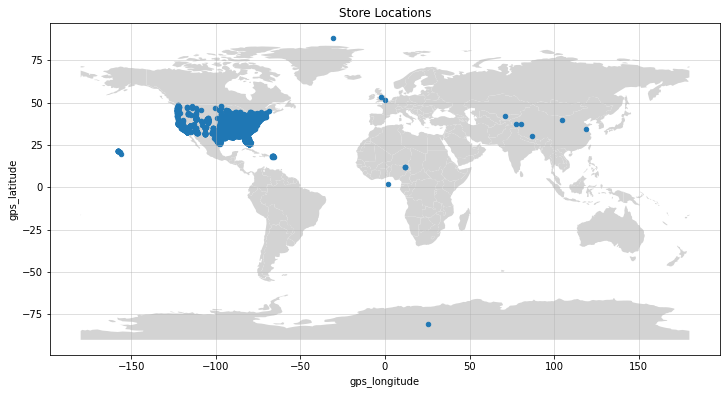

In [8]:
# Initialize an axis
fig, ax = plt.subplots(figsize=(12,10))

countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres")
)

countries.plot(color="lightgrey", ax=ax)

# Plot points
df.plot(
    x="gps_longitude", 
    y="gps_latitude", 
    kind="scatter", 
    colormap="YlOrRd", 
    title='Store Locations', 
    ax=ax)

# Add grid
ax.grid(b=True, alpha=0.5)
plt.show()

In [9]:
# Filter to points only within the US
us_map = countries.loc[countries['name'] == 'United States of America']

In [10]:
# Ensure the coordinate reference system is established for the 'us_map' 
us_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
gdf = gdf.set_crs('EPSG:4326')

In [12]:
# Spatial join - Keeps only points within the US 
gdf_us = gpd.sjoin(gdf, us_map, how='inner')

In [13]:
gdf_us = gdf_us.drop(columns = ['continent', 'pop_est', 'name', 'iso_a3', 'gdp_md_est', 'index_right' ])

### Current Map 
We can see that in our current map, we have both CONUS and Hawa'ii store locations - we can remove the store locations from Hawa'ii, as we don't have hexbin information to attribute to these store locations. 

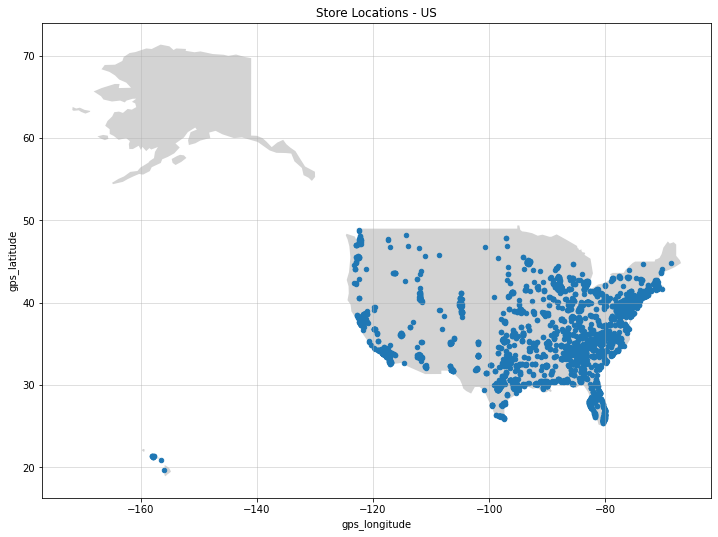

In [14]:
# Initialize an axis
fig, ax = plt.subplots(figsize=(12,10))
# Plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries[countries['name'] == 'United States of America'].plot(color="lightgrey", ax=ax)

# Plot points
gdf_us.plot(
    x="gps_longitude", 
    y="gps_latitude", 
    kind="scatter", 
    colormap="YlOrRd", 
    title='Store Locations - US', 
    ax=ax)

# Add grid
ax.grid(b=True, alpha=0.5)
plt.show()

In [15]:
# Remove Hawaii - no hexbins in that area
gdf_us = gdf_us.loc[gdf_us.state != 'HI']

In [16]:
gdf_us = gdf_us.rename(columns = {
    'gps_latitude': 'lat', 
    'gps_longitude': 'lon'
})

### Clean data
We now have just the stores that are located within CONUS, which we can now use in spatial analysis, such as determining the hexbins within a certain range of each store and aggregating the data. Additionally, we can clean out the attribute data by keeping only the stores that are in our spatial dataframe (we will also keep the data that did not fit for further analysis). 

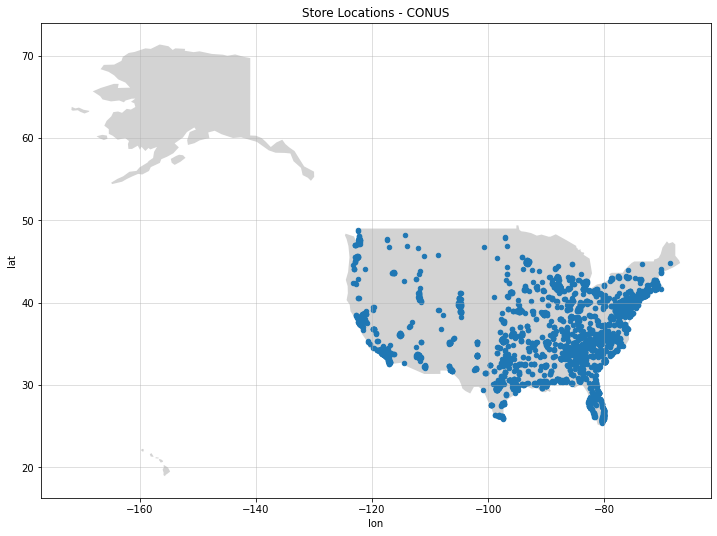

In [17]:
# Initialize an axis
fig, ax = plt.subplots(figsize=(12,10))

# Plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres")
)
countries[countries['name'] == 'United States of America'].plot(color="lightgrey", ax=ax)

# Plot points
gdf_us.plot(
    x="lon", 
    y="lat", 
    kind="scatter",   
    colormap="YlOrRd", 
    title='Store Locations - CONUS', 
    ax=ax)

# Add grid
ax.grid(b=True, alpha=0.5)
plt.show()

In [18]:
# Keep attribute data of store locations within CONUS
df_attr = df_attr.merge(gdf_us, left_on = 'ID_Store', right_on = 'ID_Store')

In [19]:
# Write out attribute data as .csv
cols = ['ID_Store', 'geometry', 'lat', 'lon']
gdf_us = gdf_us[cols]

### Exporting the Data
As noted in the '01_HexBinConversion' User guide, there are many ways to export the data - below are some examples of how to export in different formats. 

In [20]:
# Attribute Data 

# Athena needs csv to not have a header
df_attr.to_csv("../../01_Data/03_CSV_Athena/store_loc_attr.csv", index = False, header = False)
# For other purposes, .csv should have header
df_attr.to_csv("../../01_Data/04_CSV_Full/store_loc_attr.csv", index = False, header = True)

# Spatial Data

gdf_us.to_file("../../01_Data/02_GeoJSON/store_loc.geojson", driver='GeoJSON')
# Athena needs csv to not have a header
gdf_us.to_csv("../../01_Data/03_CSV_Athena/store_loc.csv", index = False, header = False)
# For other purposes, .csv should have header
gdf_us.to_csv("../../01_Data/04_CSV_Full/store_loc.csv", index = False, header = True)